In [1]:
import pickle
from datetime import date

import numpy as np
import pandas as pd

from pymc3_hmm.utils import plot_split_ts_histograms

In [2]:
def simulate_time_series(M, a, b, c, d, e, sigma, **dtr_kwargs):
    """Simulate a sine wave with Gaussian noise
    i.e. y = e * (a * sin(b * x + c) + d) + sigma * normal(N)
    """
    time_index = pd.date_range(**dtr_kwargs)
    N = len(time_index)
    x = np.linspace(0, 100, N)

    signal = np.tile(e * (a * np.sin(b * x + c) + d), (M, 1)).T
    noise = sigma * np.random.normal(size=(N, M))
    y = signal + noise

    wide_df = pd.DataFrame(data=y, index=time_index)
    long_df = pd.DataFrame(
        wide_df.stack(), columns=["Y_t"]
    ).reset_index(level=1).rename(columns={"level_1": "draw"})
    
    if M > 1:
        return long_df
    else:
        del long_df["draw"]
        return long_df.rename(columns={"Y_t": "observed_Y_t"}).squeeze()

In [3]:
df = simulate_time_series(
    M=500, a=10, b=1, c=0, d=50, e=100, sigma=150,
    start=date(2020, 8, 15), end=date(2021, 2, 11), freq="H"
)
observed_vals = simulate_time_series(
    M=1, a=10, b=1, c=0, d=50, e=100, sigma=3,
    start=date(2020, 8, 15), end=date(2021, 2, 11), freq="H"
)

sample_means = df.groupby(df.index).agg({"Y_t": np.mean})
nonsample_df = pd.concat([observed_vals, sample_means], axis=1)

In [4]:
def plot_fn(ax, data, **kwargs):
    ax.step(
        data.index,
        data["observed_Y_t"],
        color="red",
        label="obs",
        alpha=0.8,
        linewidth=1.5,
    )
    ax.step(
        data.index,
        data["Y_t"],
        color="green",
        label="E[Y_t]",
        alpha=0.8,
        linewidth=1.5,
    )

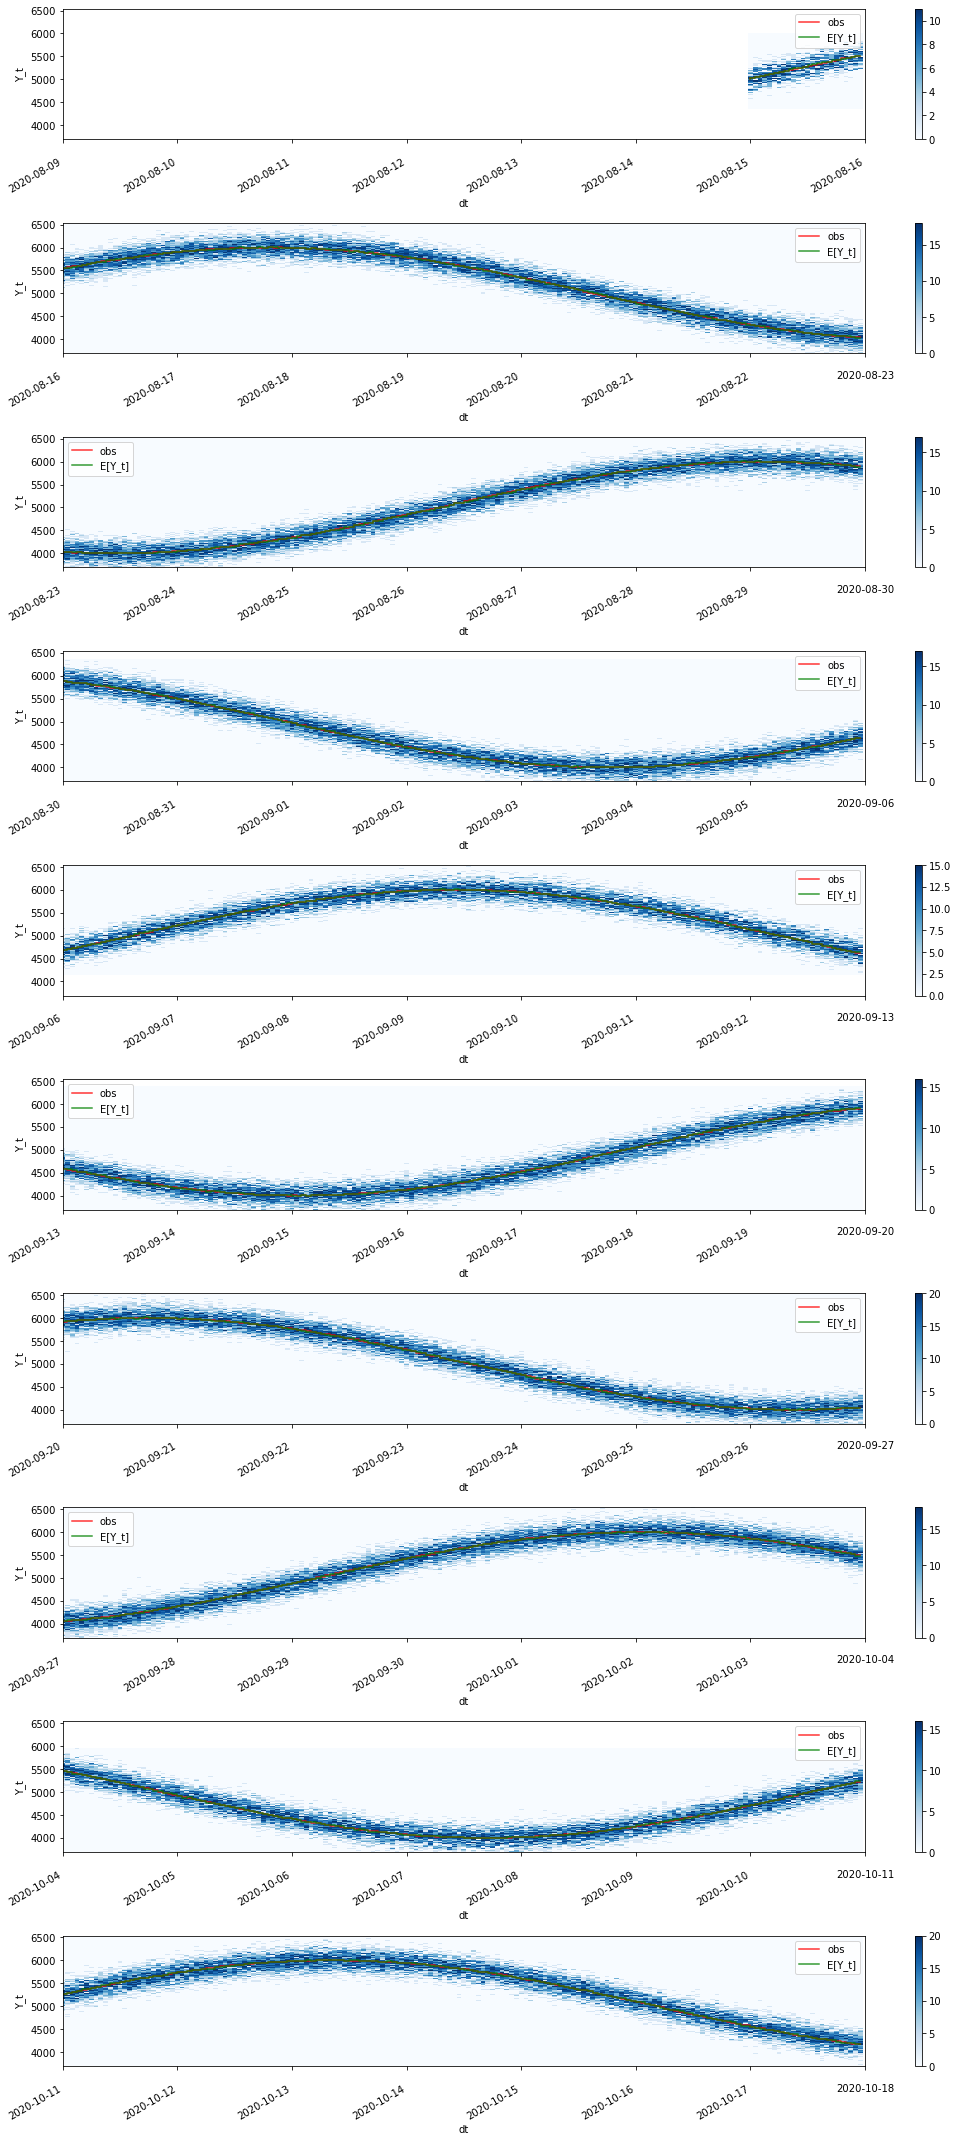

In [5]:
_ = plot_split_ts_histograms(
    df, "Y_t", nonsample_df, plot_fn,
    split_max=10, figsize=(15, 30),
)